In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import torch
import torch.nn as nn

/home/bdudas/anaconda3/envs/pct/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from omegaconf import OmegaConf


In [3]:
config = OmegaConf.load("config.yaml")
for key, value in config.items():
    print(key, value)

trainingParams {'num_epochs': 500, 'learning_rate': 0.001}
modelParams {'batch_size': 512, 'hidden_size': 128, 'input_size': 3}
numParticles 200
wptList [110, 120, 130, 140, 150, 160, 170, 180, 190, 200]


In [6]:
for wpt in config.wptList:
    cfg = config.copy()
    cfg.wptList = wpt
    print(cfg.wptList)

110
120
130
140
150
160
170
180
190
200


In [4]:
with open(f'{stringname}.yaml', 'w') as f:
    OmegaConf.save(config, f)

In [8]:
config.numParticles = 400
config.input_size = 30
print(config.input_size)

30


In [2]:
class Net(nn.Module):
    def __init__(self,batch_size:int = 128):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3, 1)
        self.batch_size = batch_size

    def forward(self, x):
        x = self.fc1(x)
        return x
x = torch.randn(128,200,3)

In [3]:
model  = Net()
output = model(x)
print(output.shape)

torch.Size([128, 200, 1])


In [4]:
paths =np.array([1,2,3,4,5,6,7,8,9,10])
np.delete(paths, [0,1,2])

array([ 4,  5,  6,  7,  8,  9, 10])

In [2]:
rootF = '/home/bdudas/PCT_DATA/output/'
wpts = [100,150,175,200]
dataFolders = [f'{rootF}/wpt_{wpt}_psa' for wpt in wpts]


In [12]:
sammpleID = 1
sampleWPT = 150

In [25]:
sampleWPT = 200
x = np.load(f'data/wpt_{sampleWPT}/{sammpleID}_x.npy')
x.shape

(818, 41)

# Load Data

In [4]:

tmp_hit = np.load(glob.glob(f"{rootF}/wpt_{sampleWPT}_psa/*_{sammpleID}.hits.npy")[0])
tmp_psa = np.load(glob.glob(f"{rootF}/wpt_{sampleWPT}_psa/*_{sammpleID}_AllPSA.npy")[0], allow_pickle=True)
hit = pd.DataFrame(tmp_hit)
psa = pd.DataFrame(tmp_psa)
hit = hit[hit.parentID == 0]
psa = psa[psa.ParentID == 0]
hit['Layer'] =  2*(hit['volumeID[2]'])+hit['volumeID[3]']


In [5]:
hit.loc[:,['eventID','posX','posY','Layer','edep']]
hit.edep = hit.edep*100


<AxesSubplot:xlabel='posX', ylabel='posY'>

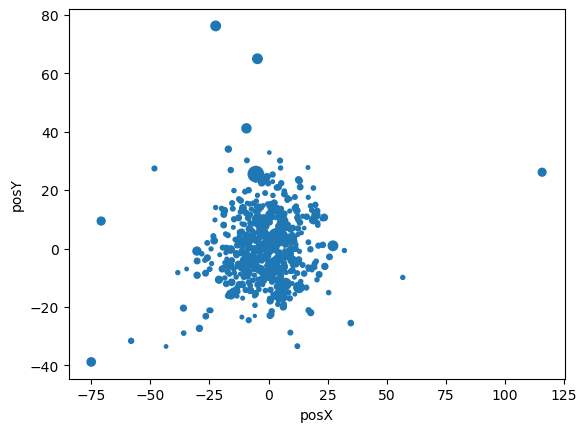

In [6]:
hit.loc[hit.Layer == 29,['posX','posY','Layer','edep']].plot.scatter(x='posX',y='posY',s ='edep',cmap='viridis')

In [7]:
df = hit.sort_values(['eventID','Layer']).loc[:,['eventID','Layer','edep']]
df

,eventID,Layer,edep
0,0,0,1.801653
1,0,1,1.640828
2,0,2,2.303419
3,0,3,1.636767
4,0,4,1.571254
...,...,...,...
29529,999,25,5.420400
29530,999,26,4.416029
29531,999,27,3.887221
29532,999,28,12.860711


array([[<AxesSubplot:title={'center':'edep'}>]], dtype=object)

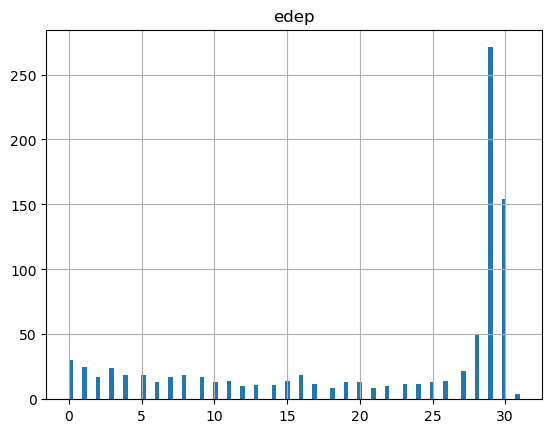

In [8]:
df.groupby('eventID').agg({'edep':np.argmax}).hist(bins=100)

In [10]:
df_psa = psa.groupby('EventID').max('Ekine').loc[:,['Ekine']]

In [11]:
df_psa.reset_index(inplace=True)
df_psa = df_psa[df_psa.EventID.isin(df.eventID)]

In [12]:
savePath = f'data/wpt_{sampleWPT}/{sammpleID}'
np.save(f'{savePath}_y.npy', df_psa.Ekine.values)
np.save(f'{savePath}_x.npy', df.edep.values)

In [13]:
all(np.load(f'{savePath}_x.npy') == df.edep.values)

True

In [14]:
def padarray(A,size = 41):
    t = size - len(A)
    if t > 0:
        return np.pad(A, (0,t), 'constant', constant_values=(0,0))
    else:
        return A

In [15]:
edep_arrays = [padarray(group['edep'].values) for _, group in df.groupby('eventID')]

In [16]:
np.save('tmp.npy', edep_arrays)
xx = np.load('tmp.npy')
xx.shape

(910, 41)

# Vencel 

In [18]:
argmaxes = np.load('utils/wpt_100_armgxs.npy')
target_layer = np.argmax(np.bincount(argmaxes))

(23981, 3)

In [27]:
cond1 = df.Layer == target_layer
cond2 = df.Layer == target_layer - 1
cond3 = df.Layer == target_layer + 1

res = df[cond1 | cond2 | cond3].pivot_table(index='eventID', columns='Layer', values='edep', fill_value=0).values


res[50:70]

array([[0.05933242, 0.136045  , 0.41957772],
       [0.07659043, 0.        , 0.        ],
       [0.04965688, 0.06861734, 0.        ],
       [0.06901675, 0.13871664, 0.        ],
       [0.08253153, 0.07521822, 0.16795959],
       [0.06441727, 0.10929828, 0.        ],
       [0.11479983, 0.3152778 , 0.        ],
       [0.05393744, 0.08693428, 0.18565749],
       [0.0848097 , 0.14005467, 0.        ],
       [0.06420419, 0.10098357, 0.        ],
       [0.07165476, 0.19999348, 0.        ],
       [0.05894753, 0.15496941, 0.        ],
       [0.08641156, 0.09929908, 0.        ],
       [0.07915997, 0.0828988 , 0.        ],
       [0.08825882, 0.06909112, 0.15938957],
       [0.05990752, 0.11625585, 0.        ],
       [0.05854087, 0.10212394, 0.        ],
       [0.07793713, 0.22526488, 0.        ],
       [0.0683246 , 0.06884488, 0.20968513],
       [0.04697396, 0.07475497, 0.10076474]], dtype=float32)

# Prediction

In [13]:
x = np.load(f'data/wpt_{sampleWPT}/{sammpleID}_x.npy')
y = np.load(f'data/wpt_{sampleWPT}/{sammpleID}_y.npy')

In [12]:
argmxs = np.argmax(x,axis=1)
mostPopularLayer = np.bincount(argmxs).argmax()
mostPopularLayer

20

In [29]:
for wpt in wpts:
    tmp = np.load(f'utils/wpt_{sampleWPT}_armgxs.npy')
    mostCommonValue = np.bincount(tmp).argmax()
    np.save(f'utils/wpt_{wpt}_targetlayer.npy', mostCommonValue)


In [45]:
x = np.load(f'data/wpt_{sampleWPT}/{sammpleID}_x.npy')
y = np.load(f'data/wpt_{sampleWPT}/{sammpleID}_y.npy')
targetlayer = np.load(f'utils/wpt_{sampleWPT}_targetlayer.npy')

In [62]:
from utils.filter import layer_filter

In [53]:
argmxs = np.argmax(x, axis=1)
c1 = argmxs == targetlayer
c2 = argmxs == targetlayer-1
c3 = argmxs == targetlayer+1
argmxs[c1 | c2 | c3].shape

(475,)

In [70]:
c1

array([False, False, False, False, False, False, False, False, False,
       False, False,  True, False,  True,  True, False, False, False,
       False, False, False, False, False,  True,  True, False, False,
        True,  True, False,  True,  True,  True, False, False, False,
        True, False, False, False, False,  True, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False,  True, False, False,  True, False, False,  True, False,
       False,  True, False, False,  True,  True, False, False,  True,
       False,  True, False,  True, False, False,  True, False, False,
       False, False,  True, False, False, False, False, False, False,
        True, False, False, False, False, False,  True, False, False,
       False, False, False,  True,  True, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False,  True,

In [71]:
def getPeakData(x,targetlayer):
    x1 = x[:,targetlayer]
    x2 = x[:,targetlayer-1]
    x3 = x[:,targetlayer+1]
    x = np.column_stack((x1,x2,x3))
    return x

In [73]:
tmpx,tmpy = layer_filter(x, y, targetlayer)

tmpx.shape

(475, 41)

In [74]:
tmpx = tmpx[:200]

In [77]:
tmpx.shape

(200, 41)

# Torch